# Постановка задачи

Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

## Импорты

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

## Загрузка данных

In [59]:
df = pd.read_csv("data/creditcard.csv")

In [60]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Работа с данными

Вот что нам говорит описание этого датасета:

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, произошедшие за два дня, где мы имеем 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет 0,172 % от всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, по соображениям конфиденциальности мы не можем предоставить исходные признаки и более подробную информацию о данных. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA, - это "Время" и "Сумма". Признак "Время" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Характеристика "Сумма" - это сумма транзакции. Эта характеристика может быть использована для обучения с учетом затрат в зависимости от примера. Признак "Класс" - это переменная отклика, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Ввиду того, что исходные данные прошли через PCA, понять, что значат признаки V1, V2, и т.д. не представляется возможным.

Имеется только три столбца, оставленные неизмененными:
- *Time* - содержит секунды, прошедшие между текущей транзакцией и первой транзакцией в наборе
- *Amount* - это сумма транзакции.
- *Class* - это переменная отклика, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

In [61]:
null = df.isna().sum()
null

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Проверим наличие дубликатов:

In [62]:
duplicates = df.duplicated()
print(duplicates.sum())

1081


У нас имеется 1081 дубликат, их нужно удалить:

In [63]:
df_len = len(df)
df = df.drop_duplicates()
print(f"Число строк в исходной выборке сократилось на {df_len - len(df)}")

Число строк в исходной выборке сократилось на 1081


Теперь в данных нет дублирования.

Теперь посмотрим какой процент мошеннических операций от общей выборки:

In [64]:
percent = round(df.Class.value_counts()[1] / len(df) * 100, 2)
print(f"Процент мошеннических операций: {percent}%")

Процент мошеннических операций: 0.17%


Видно, что процент мошеннических операций очень мал, что говорит о несбалансированности классов.

Посмотрим на основные статистики признаков:

In [65]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Имеются ли сильно кореллирующие параметры?

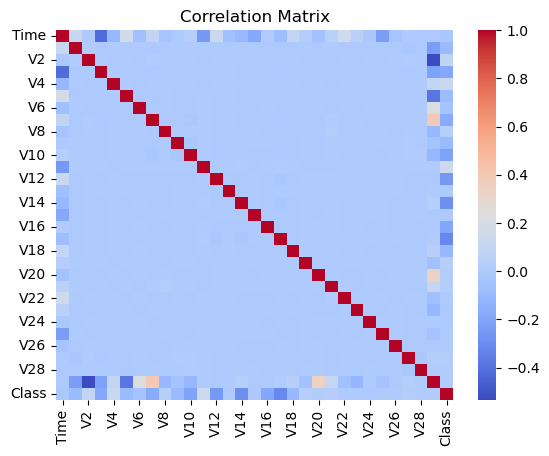

In [66]:
sns.heatmap(df.corr(), cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Видно, что данные плохо коррелируют между собой. Однако, некоторая корреляция с другими признаками наблюдается у amount. Также есть некоторая корреляция у целевой переменной с некоторыми признаками V1, V2 и т.д.

Попробуем визуализировать данные, в виду большого числа признаков, построим лишь некоторые из них:

Есть ли в данных аномалии? для этого построим ящики с усами

# Ответ на вопрос 2

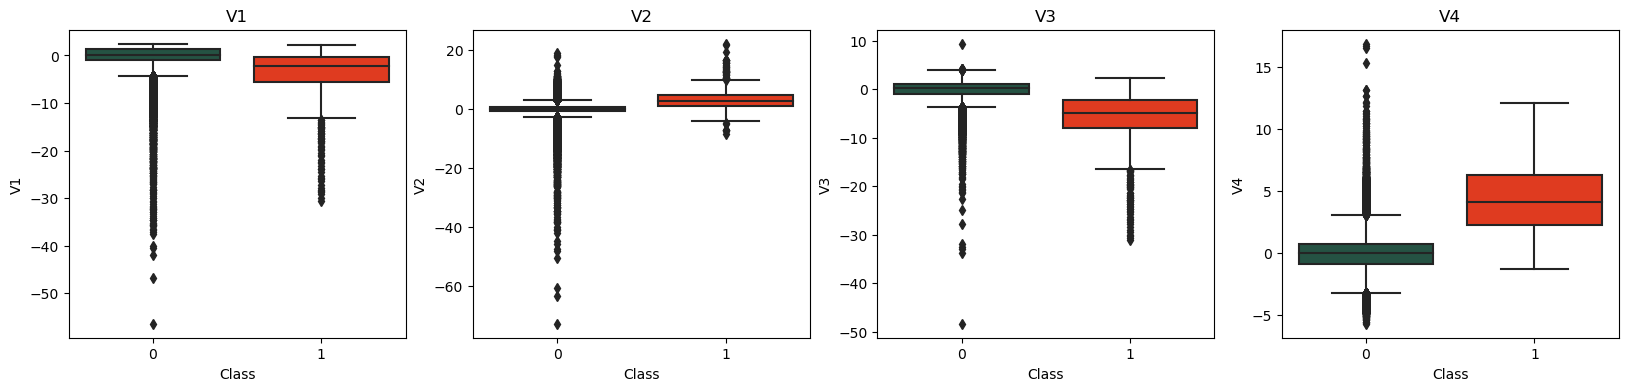

In [67]:
colors = ["#1E5945", "#FF2400"]
f, axes = plt.subplots(ncols=4, figsize=(20,4))
sns.boxplot(x="Class", y="V1", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V1')
sns.boxplot(x="Class", y="V2", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V2')
sns.boxplot(x="Class", y="V3", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V3')
sns.boxplot(x="Class", y="V4", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V4')

plt.show()

Выше представлены ящики с усами для первых четырёх признаков. Видно, что вне усов есть множество выбросов. Это и есть аномалии. В зависимости от задачи их можно убирать, например, один из способов - убрать все данные, что находятся вне усов, или вне какого-то иного диапазона. Однако, в виду специфики задачи, а именно определения мошеннических операций, убирая выбросы в данных, мы рискуем потерять важную информацию. Поэтому, как мне кажется, лучше оставить всё как есть и решать задачу классификации с имеющимися данными.  

Как связаны между собой признаки?(Очень долго работает, расскоментировать при необоходимости)

In [68]:
"""
features_to_plot = ["Time","Amount", "V1", "V2", "V3", "Class"]
subset = df[features_to_plot]
sns.pairplot(subset, hue="Class")
"""

'\nfeatures_to_plot = ["Time","Amount", "V1", "V2", "V3", "Class"]\nsubset = df[features_to_plot]\nsns.pairplot(subset, hue="Class")\n'

## Работа с моделями

В первую очередь разделим данные на тренировочные и тестовые, сохраняя при этом соотношение классов в выборке, для этого воспользуемся гиперпараметром stratify.

In [69]:
X = df.drop(["Class"], axis = 1)
y = df.Class

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

Проверим сохранилось ли соотношение классов в тренировочной и тестовой выборке:

In [71]:
print(f"В тренировочной выборке всего {round(y_train.value_counts()[1] / y_train.shape[0] * 100, 2)}% мошеннических транзакций")
print(f"В тестовой выборке всего {round(y_test.value_counts()[1] / y_test.shape[0] * 100, 2)}% мошеннических транзакций")

В тренировочной выборке всего 0.17% мошеннических транзакций
В тестовой выборке всего 0.17% мошеннических транзакций


Как видно соотношение точно такое же, как и в исходной выборке.

In [72]:
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


Статистические показатели в обеих выборках близки.

Теперь данные нужно стандартизировать:

In [73]:
ss = StandardScaler()
ss.fit(X_train)

X_train_norm = pd.DataFrame(data=ss.transform(X_train), columns=ss.get_feature_names_out())
X_test_norm = pd.DataFrame(data=ss.transform(X_test), columns=ss.get_feature_names_out())

### LogisticRegression

Первое, что можно сделать, так это попробовать логистическую регрессию. Так как в ней в кач-ве функционала ошибки выступает LogLoss, то перебалансировка противопаказана. Однако, как плюс, этот метод может работать и с несбалансированными данными.

Если коротко, то логистическая регрессия это линейный метод, который моделирует линейные отношения между входными признаками и выходным ответом.

In [74]:
logistic_regression = LogisticRegression(class_weight="balanced")
logistic_regression.fit(X_train_norm, y_train);

In [75]:
y_logistic_regression_pred = logistic_regression.predict(X_test_norm)

print(classification_report(y_test, y_logistic_regression_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



О чём нам говорит этот отчёт?
Имеется метрика *recall*, она показывает, сколько положительных прогнозов на самом деле оказались верными. Здесь он высокий, это хорошо.
Однако, с другой стороны *precision* оказался всего 5%, это означает, что всего 5% значений, принадлежащих классу 1 (они же мошеннические операции) было обнаружено, что очень мало.

## RandomForestClassifier

Теперь попробуемс случайный лес, это нелинейный метод, который строит дерево решений, где каждый узел представляет собой условие на одном из признаков.

Так как зависимость между данными была нелинейна, то, вероятнее всего, эта модель покажет себя лучше логистической регресси, которая является линейной.

In [76]:
X = df.drop(["Class"], axis = 1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

ss = StandardScaler()
ss.fit(X_train)

X_train_norm = pd.DataFrame(data=ss.transform(X_train), columns=ss.get_feature_names_out())
X_test_norm = pd.DataFrame(data=ss.transform(X_test), columns=ss.get_feature_names_out())

In [77]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train_norm, y_train);

In [78]:
y_random_forest_pred = random_forest.predict(X_test_norm)

In [79]:
print(classification_report(y_test, y_random_forest_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.78      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118



Метрика *recall* несколько снизилась, однако *precision* теперь 0.96, что не значительно больше, нежели прошлая модель.

# Ответ на вопрос 1

# Undersampling

Попробуем перебалансировать данные, чтобы размерности классов совпали. Для этого прибегнем к undersampling'у. 

In [80]:
df = df.sample(frac=1, random_state=42)
fraud_operations_df = df.loc[df['Class']==1]
num_of_fraud_operations = fraud_operations_df.shape[0]
normal_operations = df.loc[df['Class']==0][:num_of_fraud_operations]
undersampled_df = pd.concat([fraud_operations_df, normal_operations])

undersampled_df = undersampled_df.sample(frac=1, random_state=42)

Проверим доли классов в новой выборке:

In [81]:
print(f'Доля классов в выборке:')
print(undersampled_df['Class'].value_counts()/len(undersampled_df))

Доля классов в выборке:
Class
1    0.5
0    0.5
Name: count, dtype: float64


Получили одинаковые доли, теперь посмотрим на корреляцию признаков

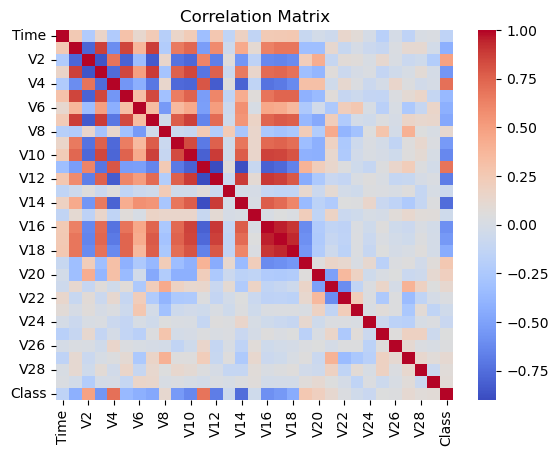

In [82]:
sns.heatmap(undersampled_df.corr(), cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Выше представлена матрица корреляции для перебалансированного набора данных. Вообще говоря, как я понял, матрицу корреляции некорректно строить для переблансированного набора, так как мы вручную переделали датасет и теперь данные не отображают действительность. Более того, между признаками появилась корреляция.

К чему это может привести? 
Подобное явление затрутдняет определение точного влияния каждого признака на целевую переменную. Это усложняет интерпритацию данных.

Одно из возможных решений - тем или иным образом сократить размерность, например с помощью того же PCA, однако, не понятно насколько это улучшит решение, поэтому в решении далее сокращения размерности не будет сделано.

Посмотрим, как тут данные зависят друг от друга

C:\Users\Ega22\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


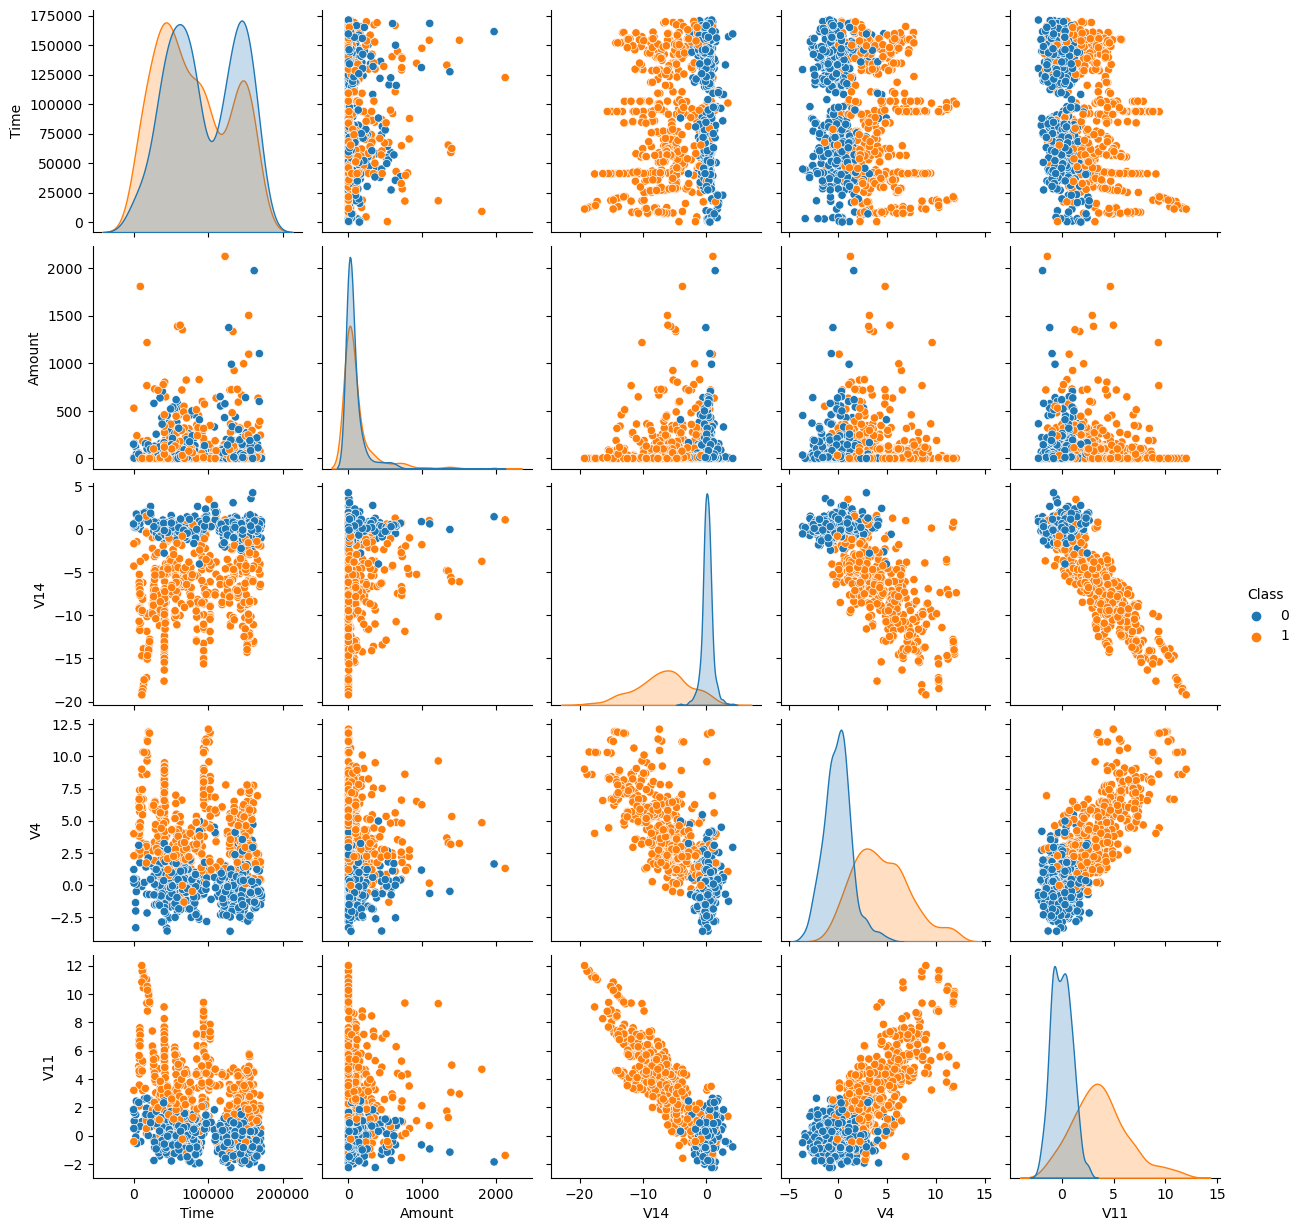

In [83]:
features_to_plot = ["Time","Amount", "V14", "V4", "V11", "Class"]
subset = undersampled_df[features_to_plot]
sns.pairplot(subset, hue="Class")

Для набора видно, что визуально данные стали более разделимы. В большинстве своем, можно разделить их, проведя прямую между разными классами. Потенциально, это говорит от том, что линейные модели будут лучше работать.

## Работа с моделями

In [84]:
X_undersampled = undersampled_df.drop(["Class"], axis = 1)
y_undersampled = undersampled_df.Class

In [85]:
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_undersampled, test_size = 0.3, stratify = y_undersampled, random_state = 42)

In [86]:
print(f"В тренировочной выборке всего {round(y_train_undersampled.value_counts()[1] / y_train_undersampled.shape[0] * 100, 2)}% мошеннических транзакций")
print(f"В тестовой выборке всего {round(y_test_undersampled.value_counts()[1] / y_test_undersampled.shape[0] * 100, 2)}% мошеннических транзакций")

В тренировочной выборке всего 50.0% мошеннических транзакций
В тестовой выборке всего 50.0% мошеннических транзакций


In [87]:
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


Видно, что выборки между собой достаточно похожи

In [88]:
ss = StandardScaler()
ss.fit(X_train_undersampled)

X_train_undersampled_norm = pd.DataFrame(data=ss.transform(X_train_undersampled), columns=ss.get_feature_names_out())
X_test_undersampled_norm = pd.DataFrame(data=ss.transform(X_test_undersampled), columns=ss.get_feature_names_out())

## LogisticRegression

In [89]:
logistic_regression_undersampled = LogisticRegression(class_weight="balanced")
logistic_regression_undersampled.fit(X_train_undersampled_norm, y_train_undersampled);

In [90]:
y_logistic_regression_undersampled_pred = logistic_regression_undersampled.predict(X_test_undersampled_norm)

print(classification_report(y_test_undersampled, y_logistic_regression_undersampled_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       142
           1       0.97      0.89      0.93       142

    accuracy                           0.93       284
   macro avg       0.93      0.93      0.93       284
weighted avg       0.93      0.93      0.93       284



## RandomForestClassifier

In [91]:
random_forest_classifier_undersampled = RandomForestClassifier(class_weight="balanced")
random_forest_classifier_undersampled.fit(X_train_undersampled_norm, y_train_undersampled);

In [92]:
y_random_forest_classifier_undersampled_pred = random_forest_classifier_undersampled.predict(X_test_undersampled_norm)

print(classification_report(y_test_undersampled, y_random_forest_classifier_undersampled_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       142
           1       0.97      0.88      0.92       142

    accuracy                           0.93       284
   macro avg       0.93      0.93      0.93       284
weighted avg       0.93      0.93      0.93       284



## Итоги

Выведем все метрики, полученные для каждой модели:

In [93]:
print("-------------- Original data --------------")
print("----------- LogisticRegression ------------")
print(classification_report(y_test, y_logistic_regression_pred))
print("-------------- RandomForest ---------------")
print(classification_report(y_test, y_random_forest_pred))
print("------------ Undersampled data ------------")
print("----------- LogisticRegression ------------")
print(classification_report(y_test_undersampled, y_logistic_regression_undersampled_pred))
print("-------------- RandomForest ---------------")
print(classification_report(y_test_undersampled, y_random_forest_classifier_undersampled_pred))

-------------- Original data --------------
----------- LogisticRegression ------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118

-------------- RandomForest ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.78      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118

------------ Undersampled data ------------
----------- LogisticRegression ------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       142
           1     

В результате были обучены две модели для обнаружения мошеннических операций. 
Для этого использовались две модели *LogisticRegression* и *RandomForestClassifier*. 

Между моделями, обученными на оригинальных данных и сбалансированном наборе, видны различия. 
Главным образом, видно, что weighted f1-score, у моделей на исходном наборе выше, что говорит, что общая производительность моделей лучше.

Однако, я хочу обратить внимание на recall, он у моделей, обученных на перебалансированном классе выше. Он говорит, что модель хорошо обнаруживает положительные примеры, но при этом может упустить некоторые отрицательные примеры.

В моем понимании, в контексте обнаружения мошеннических операций этот параметр важен, так как лучше обнаруживать больше, даже ценой увеличения ложных срабатываний, нежели меньше. Поэтому я отдаю предпочтение этим моделям.